[View in Colaboratory](https://colab.research.google.com/github/x110/DLToolboxImg/blob/master/FindLR.ipynb)

## Below I show an implementation of how to find the learning rate to use when training deep neural networks. 

## Install dependencies on Google colab


In [0]:
# Prepare Machine
## install dependencies
!apt install libnvrtc8.0
!pip install mxnet-cu80
!apt-get install ffmpeg
!apt-get install imagemagick
!pip install pylidc
!pip install dicom

## Imports and functions

In [0]:
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging
import math 
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [0]:
class LRScheduler(object):
    """Base class of a learning rate scheduler.

    A scheduler returns a new learning rate based on the number of updates that have
    been performed.

    Parameters
    ----------
    base_lr : float, optional
        The initial learning rate.
    """
    def __init__(self, base_lr=0.01):
        self.base_lr = base_lr

    def __call__(self, num_update):
        """Return a new learning rate.

        The ``num_update`` is the upper bound of the number of updates applied to
        every weight.

        Assume the optimizer has updated *i*-th weight by *k_i* times, namely
        ``optimizer.update(i, weight_i)`` is called by *k_i* times. Then::

            num_update = max([k_i for all i])

        Parameters
        ----------
        num_update: int
            the maximal number of updates applied to a weight.
        """
        raise NotImplementedError("must override this")
class lr_find(LRScheduler):
    """Reduce the learning rate by a factor for every *n* steps.

    It returns a new learning rate by::

        base_lr * pow(factor, floor(num_update/step))

    Parameters
    ----------
    step : int
        Changes the learning rate for every n updates.
    factor : float, optional
        The factor to change the learning rate.
    stop_factor_lr : float, optional
        Stop updating the learning rate if it is less than this value.
        
    """

    def __init__(self, layer_opt_lr, nb, end_lr=10, linear=True):
        super(lr_find,self).__init__()

        self.linear = linear
        ratio = end_lr/layer_opt_lr
        self.lr_mult = (ratio/nb) if linear else ratio**(1/nb)
        self.iteration = 1
        self.losses=[]
        self.lrs=[]
        self.init_lrs=layer_opt_lr
        self.new_lr = self.init_lrs

    def on_train_begin(self):
        self.best=1e9
        
        
    def __call__(self,b):
        return self.new_lr



    def on_batch_end(self, loss):
        self.losses.append(loss)
        mult = self.lr_mult*self.iteration if self.linear else self.lr_mult**self.iteration
        self.iteration +=1
        self.new_lr = self.init_lrs * mult
        self.lrs.append(self.new_lr)
        return self.init_lrs * mult
        if math.isnan(loss) or loss>self.best*4:
            return True
        if (loss<self.best and self.iteration>10): self.best=loss

    def plot(self, n_skip=10):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def reset(self):
        self.iteration = 1
        self.losses=[]
        self.lrs=[]

## Data

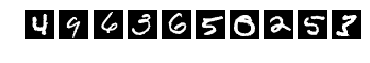

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
np.random.seed(1234) # set seed for deterministic ordering
p = np.random.permutation(mnist.data.shape[0])
X = mnist.data[p]
Y = mnist.target[p]

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X[i].reshape((28,28)), cmap='Greys_r')
    plt.axis('off')
plt.show()

X = X.astype(np.float32)/255
X_train = X[:60000]
X_test = X[60000:]
Y_train = Y[:60000]
Y_test = Y[60000:]



## Model

In [0]:
# Variables are place holders for input arrays. We give each variable a unique name.
data = mx.symbol.Variable('data')

# The input is fed to a fully connected layer that computes Y=WX+b.
# This is the main computation module in the network.
# Each layer also needs an unique name. We'll talk more about naming in the next section.
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
# Activation layers apply a non-linear function on the previous layer's output.
# Here we use Rectified Linear Unit (ReLU) that computes Y = max(X, 0).
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")

fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")

fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
# Finally we have a loss layer that compares the network's output with label and generates gradient signals.
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

In [0]:
batch_size = 100
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

In [6]:
# ==================Binding=====================
# The symbol we created is only a graph description.
# To run it, we first need to allocate memory and create an executor by 'binding' it.
# In order to bind a symbol, we need at least two pieces of information: context and input shapes.
# Context specifies which device the executor runs on, e.g. cpu, GPU0, GPU1, etc.
# Input shapes define the executor's input array dimensions.
# MXNet then run automatic shape inference to determine the dimensions of intermediate and output arrays.

# data iterators defines shapes of its output with provide_data and provide_label property.
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print ('input_shapes', input_shapes)
# We use simple_bind to let MXNet allocate memory for us.
# You can also allocate memory youself and use bind to pass it to MXNet.
exe = mlp.simple_bind(ctx=mx.gpu(0), **input_shapes)

# ===============Initialization=================
# First we get handle to input arrays
arg_arrays = dict(zip(mlp.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]

# We initialize the weights with uniform distribution on (-0.01, 0.01).
init = mx.init.Uniform(scale=0.01)
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)
    
# We also need to create an optimizer for updating weights
#opt = mx.optimizer.SGD(
    #learning_rate=0.1,rescale_grad=1.0/train_iter.batch_size,lr_scheduler=sched)
    #momentum=0.9,
    #wd=0.00001,
    #rescale_grad=1.0/train_iter.batch_size)
#updater = mx.optimizer.get_updater(opt)

# Finally we need a metric to print out training progress
metric = mx.metric.CrossEntropy() 

input_shapes {'data': (100, 784), 'softmax_label': (100,)}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.


In [7]:
nb = len(X_train)/batch_size
nb

600.0

In [0]:
sched=lr_find(1e-3,nb,end_lr=1)

In [0]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=1,
    momentum=0.9,
    wd=0.00001,
    rescale_grad=1.0/train_iter.batch_size,lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)


In [0]:
metric = mx.metric.CrossEntropy() 

In [11]:
counter=0
# Training loop begines
for epoch in range(1):
    train_iter.reset()
    metric.reset()
    sched.reset()
    t = 0
    sched.on_train_begin()

    for batch in train_iter:

        data[:] = batch.data[0]
        label[:] = batch.label[0]
        outputs=exe.forward(is_train=True)
        exe.backward()
        
        # Update
        tmp=0

        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
            tmp+=1
        counter+=1   
        metric.update(batch.label, exe.outputs)
        e=metric.get()
        err_train=e[1]
        sched.on_batch_end(err_train)#loss)

        t += 1
        if t % 100 == 0:
            print('epoch:', epoch, 'iter:', t, 'metric:', metric.get())
  

epoch: 0 iter: 100 metric: ('cross-entropy', 2.299421466064453)
epoch: 0 iter: 200 metric: ('cross-entropy', 1.7072034585952758)
epoch: 0 iter: 300 metric: ('cross-entropy', 1.3090668846766154)
epoch: 0 iter: 400 metric: ('cross-entropy', 1.1494513531684876)
epoch: 0 iter: 500 metric: ('cross-entropy', 1.831294879837036)
epoch: 0 iter: 600 metric: ('cross-entropy', 1.9204962469100952)


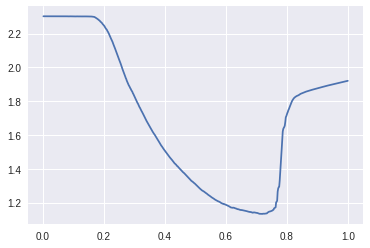

In [12]:
plt.plot(sched.lrs, sched.losses)


From the graph, we can see that the loss rate drop is larges at .5. Hence, we choose it to be our learning rate

### Learning with the suggested learning rate

In [0]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.5,rescale_grad=1.0/train_iter.batch_size)


In [0]:
updater.optimizer.lr_scheduler=None


In [0]:
updater = mx.optimizer.get_updater(opt)

In [0]:
metric = mx.metric.Accuracy()

In [17]:
# We initialize the weights with uniform distribution on (-0.01, 0.01).
init = mx.init.Uniform(scale=0.01)
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  after removing the cwd from sys.path.


In [18]:


# Training loop begines
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    t = 0
    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]
        
        # Forward
        outputs=exe.forward(is_train=True)
        
        # You perform operations on exe.outputs here if you need to.
        # For example, you can stack a CRF on top of a neural network.
        
        # Backward
        exe.backward()
        
        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
        metric.update(batch.label, exe.outputs)
        t += 1
        if t % 100 == 0:
            print('epoch:', epoch, 'iter:', t, 'metric:', metric.get())

epoch: 0 iter: 100 metric: ('accuracy', 0.1229)
epoch: 0 iter: 200 metric: ('accuracy', 0.279)
epoch: 0 iter: 300 metric: ('accuracy', 0.45813333333333334)
epoch: 0 iter: 400 metric: ('accuracy', 0.56845)
epoch: 0 iter: 500 metric: ('accuracy', 0.63782)
epoch: 0 iter: 600 metric: ('accuracy', 0.6868833333333333)
epoch: 1 iter: 100 metric: ('accuracy', 0.9413)
epoch: 1 iter: 200 metric: ('accuracy', 0.93995)
epoch: 1 iter: 300 metric: ('accuracy', 0.9443666666666667)
epoch: 1 iter: 400 metric: ('accuracy', 0.946875)
epoch: 1 iter: 500 metric: ('accuracy', 0.94878)
epoch: 1 iter: 600 metric: ('accuracy', 0.9508833333333333)
epoch: 2 iter: 100 metric: ('accuracy', 0.9634)
epoch: 2 iter: 200 metric: ('accuracy', 0.9616)
epoch: 2 iter: 300 metric: ('accuracy', 0.9643)
epoch: 2 iter: 400 metric: ('accuracy', 0.9652)
epoch: 2 iter: 500 metric: ('accuracy', 0.96646)
epoch: 2 iter: 600 metric: ('accuracy', 0.9677666666666667)
epoch: 3 iter: 100 metric: ('accuracy', 0.9737)
epoch: 3 iter: 200 me

## Learning with the a guessed learning rate

In [0]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=0.1,
    momentum=0.9,
    wd=0.00001,
    rescale_grad=1.0/train_iter.batch_size)
#updater.optimizer.lr_scheduler=None


In [0]:
updater = mx.optimizer.get_updater(opt)

In [0]:
metric = mx.metric.Accuracy()

In [22]:
# We initialize the weights with uniform distribution on (-0.01, 0.01).
init = mx.init.Uniform(scale=0.01)
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  after removing the cwd from sys.path.


In [23]:
# Training loop begines
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    t = 0
    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]
        
        # Forward
        outputs=exe.forward(is_train=True)
        
        # You perform operations on exe.outputs here if you need to.
        # For example, you can stack a CRF on top of a neural network.
        
        # Backward
        exe.backward()
        
        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
        metric.update(batch.label, exe.outputs)
        t += 1
        if t % 100 == 0:
            print('epoch:', epoch, 'iter:', t, 'metric:', metric.get())

epoch: 0 iter: 100 metric: ('accuracy', 0.1451)
epoch: 0 iter: 200 metric: ('accuracy', 0.4331)
epoch: 0 iter: 300 metric: ('accuracy', 0.5851)
epoch: 0 iter: 400 metric: ('accuracy', 0.670275)
epoch: 0 iter: 500 metric: ('accuracy', 0.72354)
epoch: 0 iter: 600 metric: ('accuracy', 0.7607333333333334)
epoch: 1 iter: 100 metric: ('accuracy', 0.9475)
epoch: 1 iter: 200 metric: ('accuracy', 0.9506)
epoch: 1 iter: 300 metric: ('accuracy', 0.9530666666666666)
epoch: 1 iter: 400 metric: ('accuracy', 0.955)
epoch: 1 iter: 500 metric: ('accuracy', 0.95706)
epoch: 1 iter: 600 metric: ('accuracy', 0.9583666666666667)
epoch: 2 iter: 100 metric: ('accuracy', 0.9688)
epoch: 2 iter: 200 metric: ('accuracy', 0.96735)
epoch: 2 iter: 300 metric: ('accuracy', 0.9693333333333334)
epoch: 2 iter: 400 metric: ('accuracy', 0.970075)
epoch: 2 iter: 500 metric: ('accuracy', 0.97054)
epoch: 2 iter: 600 metric: ('accuracy', 0.9711)
epoch: 3 iter: 100 metric: ('accuracy', 0.9741)
epoch: 3 iter: 200 metric: ('accu

## Conclusion
with the learn rate finder, we got an accuracy of .9919 whereas with the guessed learning rate we got .98896 accuracy.